### Import Package

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

### Binomial Tree

In [2]:
def call(ST,K):
    return np.maximum(ST-K, 0)

def put(ST,K):
    return np.maximum(K-ST, 0)

def BS(S, K, T, r, sigma, option):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T) / (sigma*T**0.5)
    d2 = d1 - (sigma*T**0.5)
    if option == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif option == 'put':
        return -S*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)

def binomial_tree(S, K, T, r, sigma, N, method, option, Astyle=None):
    dt = T/N # time increament
    df = np.exp(-r*dt) # discount factor

    payoff = {'call': call, 'put': put}[option]

    if method == 'CRR':
        u = np.exp(sigma*np.sqrt(dt))
        d = 1/u
        q = (np.exp(r*dt)-d) / (u-d)
    elif method == 'JR':
        u = np.exp((r-0.5*sigma**2)*dt + sigma*dt**0.5)
        d = np.exp((r-0.5*sigma**2)*dt - sigma*dt**0.5)
        q = 0.5

    stock_path = np.zeros((N+1, N+1))
    stock_path[0,0] = S
    for i in range(1, N+1):
        for j in range(i+1):
            stock_path[i,j] = S * u**(i-j) * d**j

    option_value = np.maximum(payoff(stock_path[N], K), 0)
    for i in range(N, 0, -1):
        for j in range(i):
            option_value[j] = (q * option_value[j] + (1-q) * option_value[j+1]) * df
            if Astyle == True:
                option_value[j] = max(option_value[j], payoff(stock_path[i-1, j], K))
    return option_value[0]

#### European option

Error Performance
-----------------
             0          1          2          3          4          5  \
N    10.000000  20.000000  30.000000  40.000000  50.000000  60.000000   
CRR   0.195612   0.098537   0.065843   0.049438   0.039576   0.032995   
JR    0.084747   0.021844   0.004696   0.002348   0.005784   0.007606   

             6          7          8           9  
N    70.000000  80.000000  90.000000  100.000000  
CRR   0.028290   0.024759   0.022012    0.019814  
JR    0.008603   0.009139   0.009403    0.009498  


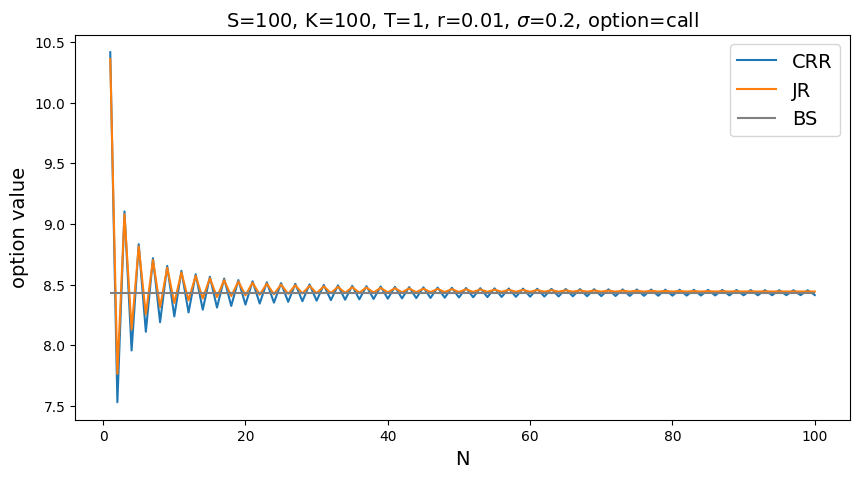

In [3]:
S = 100
K = 100
T = 1
r = 0.01
sigma = 0.2
option = 'call'
bs_res = BS(S, K, T, r, sigma, option)
N = np.arange(1, 101)
crr_res = []
jr_res = []
for n in N:
    crr_res.append(binomial_tree(S, K, T, r, sigma, n, 'CRR', option))
    jr_res.append(binomial_tree(S, K, T, r, sigma, n, 'JR', option))

analysis_N = np.arange(10, 101, 10)
error_df = pd.DataFrame({'N':analysis_N, 'CRR':np.abs(crr_res-bs_res)[analysis_N-1], 'JR':np.abs(jr_res-bs_res)[analysis_N-1]})
print('Error Performance')
print('-----------------')
print(error_df.T)

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.plot(N, jr_res, label='JR')
plt.hlines(bs_res, N[0], N[-1], color='gray', label='BS')
plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

#### American put (no dividend)

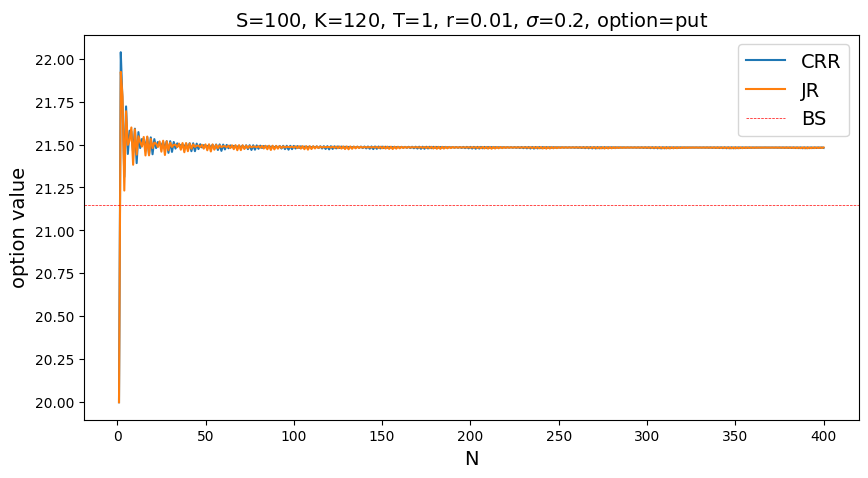

In [4]:
S = 100
K = 120
T = 1
r = 0.01
sigma = 0.2
option = 'put'
N = np.arange(1, 401)
crr_res = []
jr_res = []
for n in N:
    crr_res.append(binomial_tree(S, K, T, r, sigma, n, 'CRR', option, True))
    jr_res.append(binomial_tree(S, K, T, r, sigma, n, 'JR', option, True))

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.plot(N, jr_res, label='JR')
plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
bs_value = BS(S, K, T, r, sigma, option)  
plt.axhline(y=bs_value, color='r', linestyle='--', label=f'BS', linewidth=0.5) 
plt.legend(fontsize=14)

#### Barrier option

In [5]:
def barrier_down_call(S, K, T, r, sigma, B, type):
    bs_call = BS(S, K, T, r, sigma, 'call')
    lamb = (r+0.5*sigma**2) / sigma**2
    y = (np.log((B**2)/(S*K))) / (sigma*T**0.5) + lamb*sigma*T**0.5
    if type == 'in':
        return S * (B/S)**(2*lamb) * norm.cdf(y) - K*np.exp(-r*T) * (B/S)**(2*lamb-2) * norm.cdf(y-sigma*T**0.5)
    elif type == 'out':
        return bs_call - (S * (B/S)**(2*lamb) * norm.cdf(y) - K*np.exp(-r*T) * (B/S)**(2*lamb-2) * norm.cdf(y-sigma*T**0.5))


def binomial_tree_barrier_option(S, K, T, r, sigma, B, N, option, Astyle=None):
    dt = T/N # time increament
    df = np.exp(-r*dt) # discount factor

    payoff = {'call': call, 'put': put}[option]
    
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    q = (np.exp(r*dt)-d) / (u-d)

    stock_path = np.zeros((N+1, N+1))
    stock_path[0,0] = S
    for i in range(1, N+1):
        for j in range(i+1):
            stock_path[i,j] = S * u**(i-j) * d**j

    option_value = np.maximum(payoff(stock_path[N], K), 0) * (stock_path[N] >= B).astype(int) # Barrier condition
    for i in range(N, 0, -1):
        for j in range(i):
            option_value[j] = (q * option_value[j] + (1-q) * option_value[j+1]) * df
            if Astyle == True:
                option_value[j] = max(option_value[j], payoff(stock_path[i-1, j], K))
        option_value[:i] = option_value[:i] * (stock_path[i-1][stock_path[i-1]!=0] >= B).astype(int) # Barrier condition
    return option_value[0]

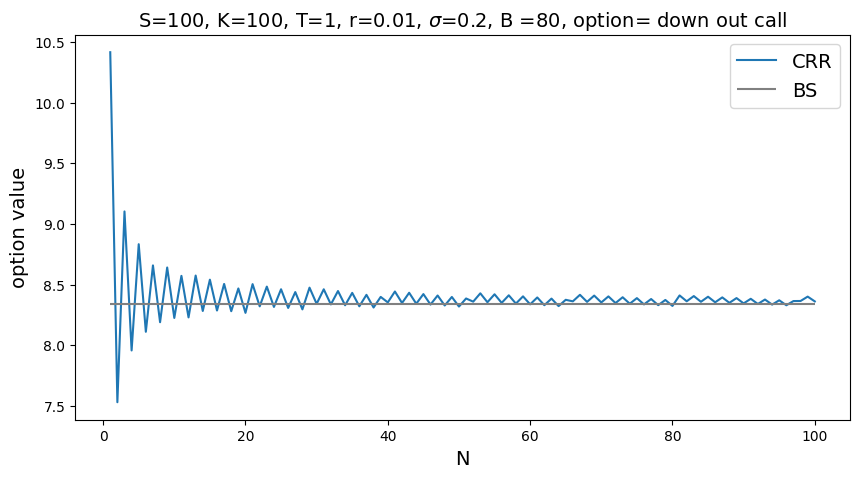

In [6]:
S = 100
K = 100
B = 80
T = 1
r = 0.01
sigma = 0.2
option = 'call'
bs_res = barrier_down_call(S, K, T, r, sigma, B, 'out')
N = np.arange(1, 101)
crr_res = []
for n in N:
    crr_res.append(binomial_tree_barrier_option(S, K, T, r, sigma, B, n, 'call'))

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.hlines(bs_res, N[0], N[-1], color='gray', label='BS')
plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, B ={B}, option= down out {option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

